# Librispeech Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH SSDs
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 20GB DDR4

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.

### Meta information

* "first" preprocessing step of listing the files was removed (check `librispeech_demo.py`) because it did not affect performance in our tests. This should be reintroduced when simulating distributed training, e.g., federated learning, where getting the file locations can actually affect performance

* Dataset size: `6.618` GB (`du -hb .` / 1000**3)
* Amount of `.flac` files: 28539 (`find . -type f | grep .flac | wc -l`)
* Avg. filesize: `0.2319` MB
* Sample sizes (rounded to second decimal):
    * `0500:  115.95 MB` 
    * `1000:  231.91 MB`
    * `2000:  463.82 MB`
    * `4000:  927.64 MB`
    * `8000: 1855.29 MB`

## Dataset General Information

In [1]:
full_dataset_filecount = 28539
for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_filecount * 100, 2)}%")

500 of total: 1.75%
1000 of total: 3.5%
2000 of total: 7.01%
4000 of total: 14.02%
8000 of total: 28.03%


In [2]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
from notebookhelper import show_values_on_bars, save_figure
from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
plotting_palette = "deep"
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context, palette=plotting_palette)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [4]:
local_fig_dir = "librispeech-pipeline/"
def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

home_path = "../logs/librispeech"
path_to_cum_df = f"{home_path}/librispeech_2021-03-12-08:31:23_cum-df_samples-500-1000-2000-4000-8000-28539_threads-1-2-4-8.csv"
path_to_cum_dstat_df = f"{home_path}/librispeech_2021-03-12-08:31:23_cum-dstat-df_samples-500-1000-2000-4000-8000-28539_threads-1-2-4-8.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                     , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
summary      = analysis.summary()
strategies   = summary.strategy.unique()
strategies_renamed = ["unprocessed", "decode-flac", "full"] #"spectrogram"]
strategies

array(['0-fully-online', '2-read-and-decode-flac',
       '3-convert-to-spectrogram'], dtype=object)

In [5]:
cum_df.head(5)

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp
0,0.000000,8,8,0.000000,28539,792.035563,36.032473,0,1,cddb20,0-fully-online,2021-03-22-16:38:28
1,539.626720,8,8,11577.701738,28539,684.548946,41.690226,0,1,854959,2-read-and-decode-flac,2021-03-22-16:38:28
2,804.108940,8,8,11572.116121,28539,18.997219,1502.272491,0,1,628c71,3-convert-to-spectrogram,2021-03-22-16:38:28
3,0.000000,8,8,0.000000,28539,801.534105,35.605472,0,1,dbfef4,0-fully-online,2021-03-22-17:28:11
4,524.872542,8,8,11583.710580,28539,680.810064,41.919181,0,1,a34110,2-read-and-decode-flac,2021-03-22-17:28:11


In [6]:
cum_dstat_df.head(5)

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,split_name,creation_timestamp
0,0.0,0.014190,0.039282,0.000000,0.000000,0,28539,8,8,cddb20,0-fully-online,2021-03-22-16:38:28
1,1.0,36.843520,0.000000,0.001439,0.014494,0,28539,8,8,cddb20,0-fully-online,2021-03-22-16:38:28
2,2.0,15.212544,0.000000,3.367274,0.086320,0,28539,8,8,cddb20,0-fully-online,2021-03-22-16:38:28
3,3.0,0.012288,1.560576,7.331138,0.110502,0,28539,8,8,cddb20,0-fully-online,2021-03-22-16:38:28
4,4.0,0.000000,0.000000,7.694932,0.117139,0,28539,8,8,cddb20,0-fully-online,2021-03-22-16:38:28


## 0. Experiment Information

### 0.1 Experiment Count
We define an experiment as profiling a materialization strategy (e.g., `0-fully-online`) with a certain sample count (e.g, `500`).

We replicated **every** experiment **5** times, that means we should have `5 * <mat-strategies> * <thread_count>` experiments for each sample size. The only exception is the full dataset preprocessing, which is ran with `thread_count = 8`.

`norm_thread_experiment_count` should be `5` for all.

Unfortunately the `ueid`s are based on the way the experiments were ran (in the python loop vs. bash loop), so we only count the rows, as each row in the `cum_df` dataframe is a single experiment.

In [7]:
experiment_count_dict = {
    "sample_count": []
  , "sample_experiment_count": []
  , "thread_count": []
  , "thread_experiment_count": []
  , "norm_thread_experiment_count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(sample_count, sample_experiment_count
              , thread_count, thread_experiment_count, norm_thread_experiment_count):
    '''Short helper'''
    experiment_count_dict["sample_count"] += [sample_count]
    experiment_count_dict["sample_experiment_count"] += [sample_experiment_count]
    experiment_count_dict["thread_count"] += [thread_count]
    experiment_count_dict["thread_experiment_count"] += [thread_experiment_count]
    experiment_count_dict["norm_thread_experiment_count"] += [norm_thread_experiment_count]

for sample_count in cum_df["sample_count"].unique():
    sample_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count}'))
    for thread_count in cum_df.query(f'sample_count=={sample_count}')['thread_count'].unique():
        thread_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count}'))
        norm_thread_experiment_count = thread_experiment_count / len(strategies)
        add_to_dict(sample_count, sample_experiment_count,
                    thread_count, thread_experiment_count, norm_thread_experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

,sample_count,sample_experiment_count,thread_count,thread_experiment_count,norm_thread_experiment_count
0,28539,15,8,15,5.0
1,500,60,1,15,5.0
2,500,60,2,15,5.0
3,500,60,4,15,5.0
4,500,60,8,15,5.0
5,1000,60,1,15,5.0
6,1000,60,2,15,5.0
7,1000,60,4,15,5.0
8,1000,60,8,15,5.0
9,2000,60,1,15,5.0


# 1. Storage Consumption Analysis

## 1.1 Uncompressed dataset storage consumption compared the different strategies

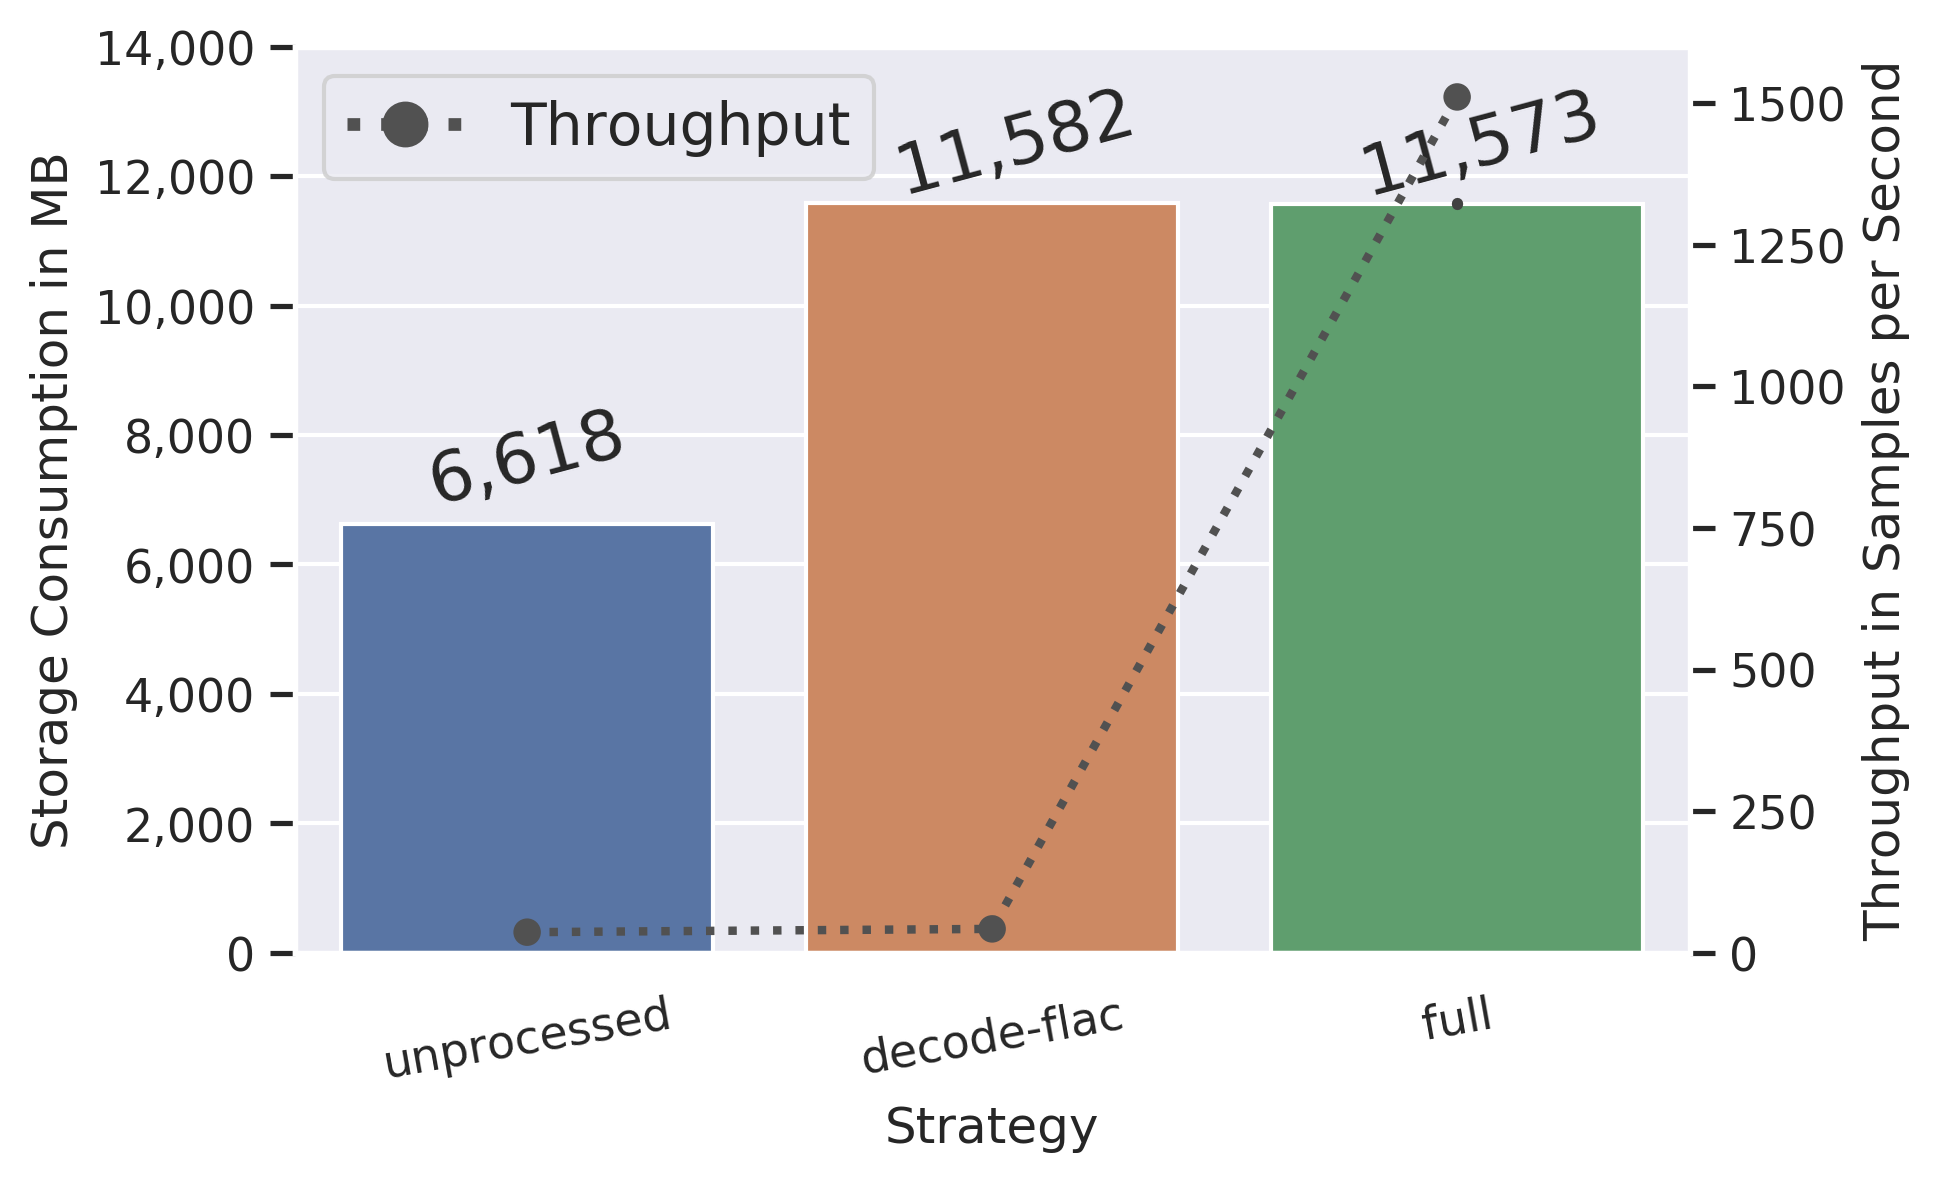

In [8]:
sample_size_mb_dict = {
    "500": 115.95
  , "1000": 231.91
  , "2000": 463.82
  , "4000": 927.64
  , "8000": 1855.29
  , "28539": 6618.00
}
storage_consumption_comparison = {
    "storage_consumption": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df.sample_count.unique():
    for i, strategy in enumerate(strategies):
        shard_sizes_mb = cum_df.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()        
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.set(font_scale=1.4)

## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps",
                    data=cum_df.query(f"sample_count=={np.max(cum_df.sample_count.unique())}"),
                    ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples per Second")
plot2.set_xticklabels(
    strategies_renamed
  , rotation=20
)
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=10, color=throughput_color, lw=3.05, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 14})
plot2.set(ylim=(0, 1600))          


plot = sns.barplot(
        x="strategy",
        y="storage_consumption",
        data=storage_df.query(f"sample_count=={np.max(cum_df.sample_count.unique())}"),
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
show_values_on_bars(plot, h_v="v", space=1100, rotation=15, additional_x_space=[0, 0.05, 0.05])
plot.set(ylabel="Storage Consumption in MB", xlabel="Strategy")
plot.set(ylim=(0, 14000))

# FuncFormatter can be used as a decorator
@ticker.FuncFormatter
def major_formatter(value, pos):
    return re.sub(r'(?<!^)(?=(\d{3})+$)', r',', str(value)[0:-2])

plot.yaxis.set_major_formatter(major_formatter)
save_fig("storage-consumption")

# 2. Preprocessing Time Analysis

## 2.1 Preprocessing time plots

[(0, 1400)]

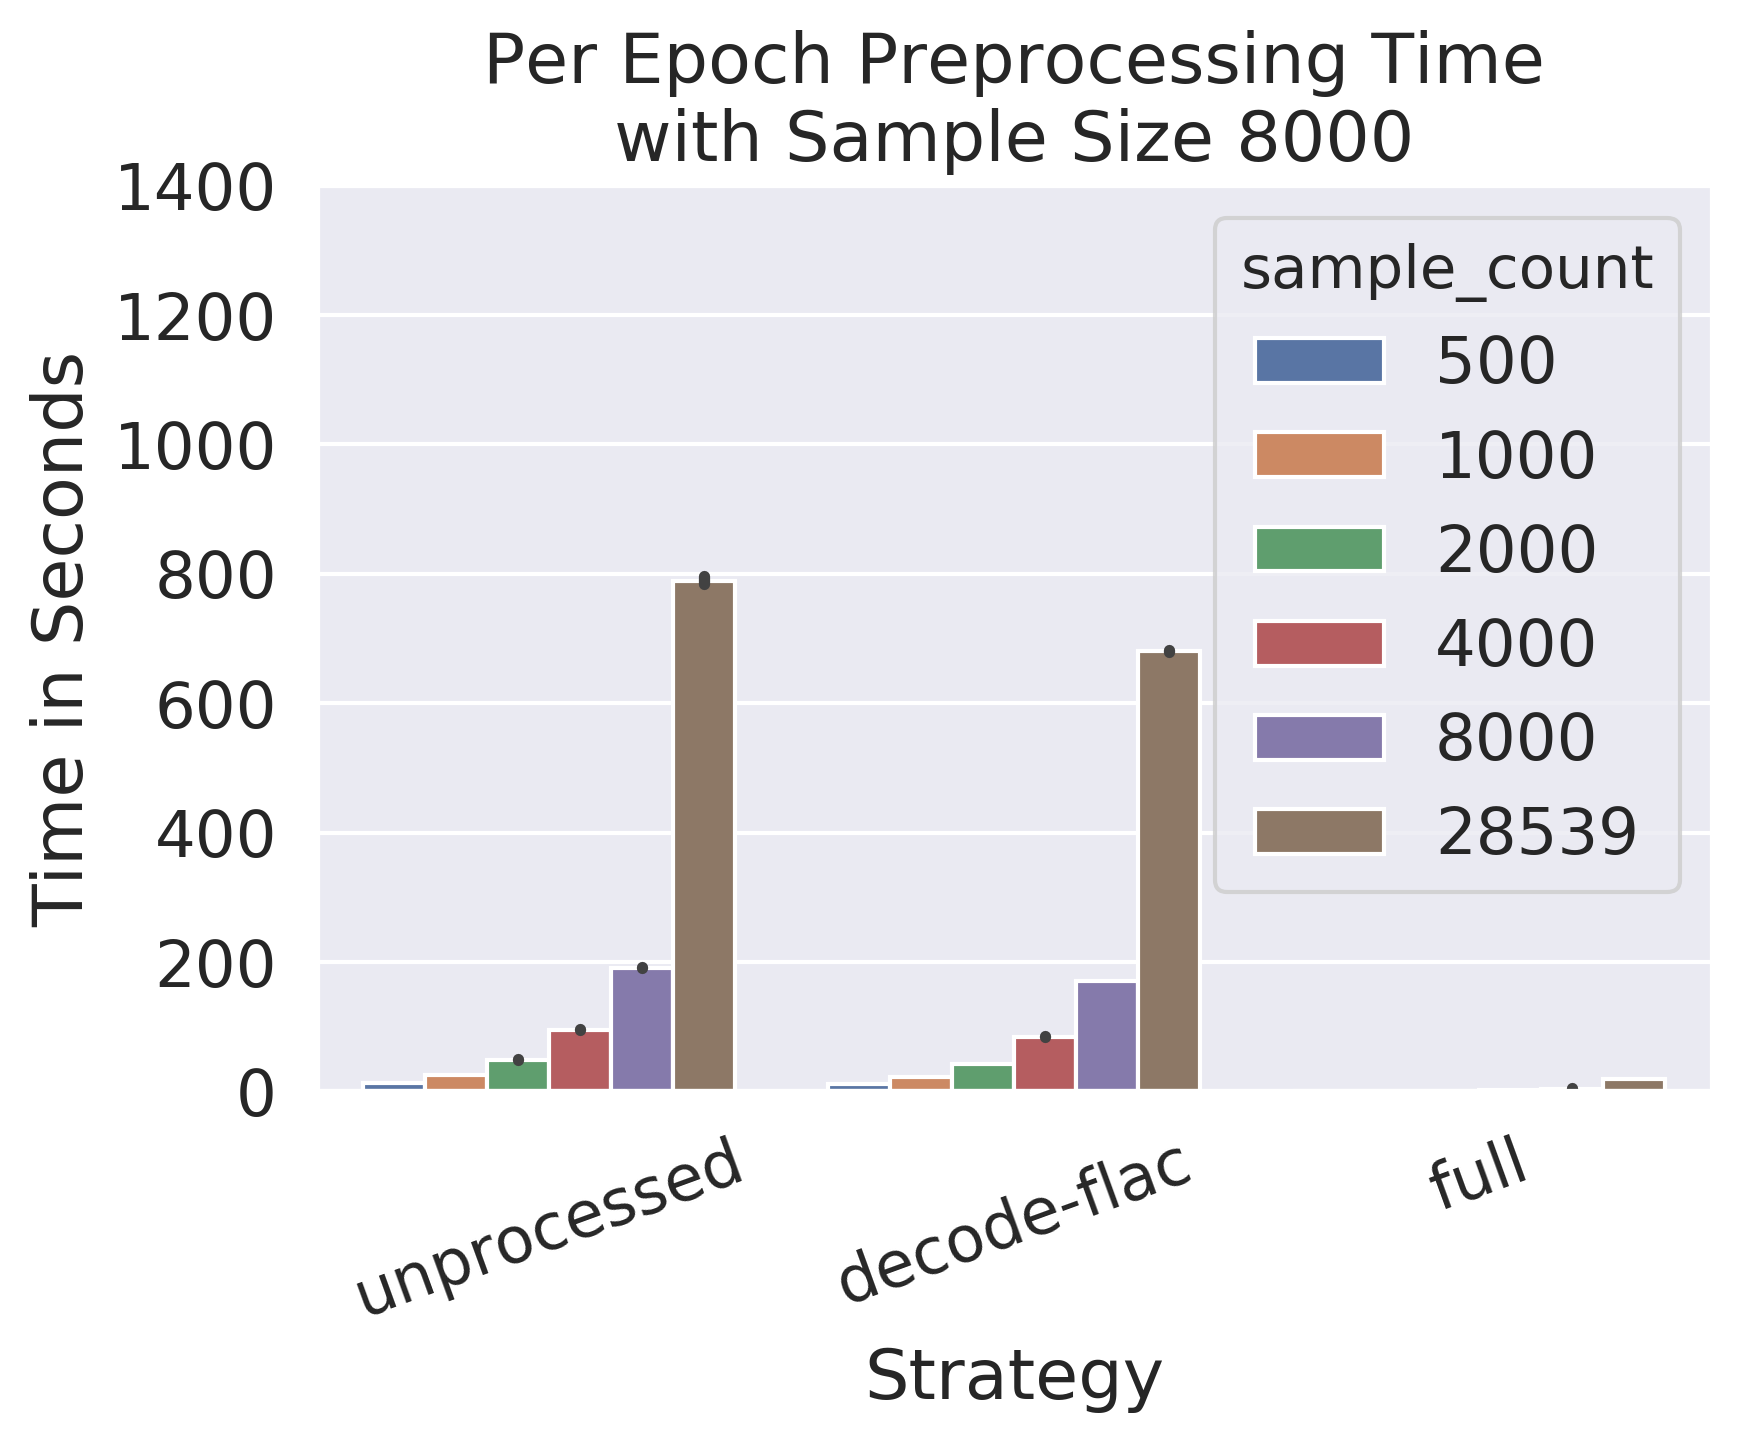

In [9]:
plot = sns.barplot(
    x="split_name",
    y="online_processing_time_s",
    hue="sample_count",
    data=cum_df.query(f"thread_count==8")
)
plot.set_title(f"Per Epoch Preprocessing Time\n with Sample Size 8000 {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 1400))

[(0, 1400)]

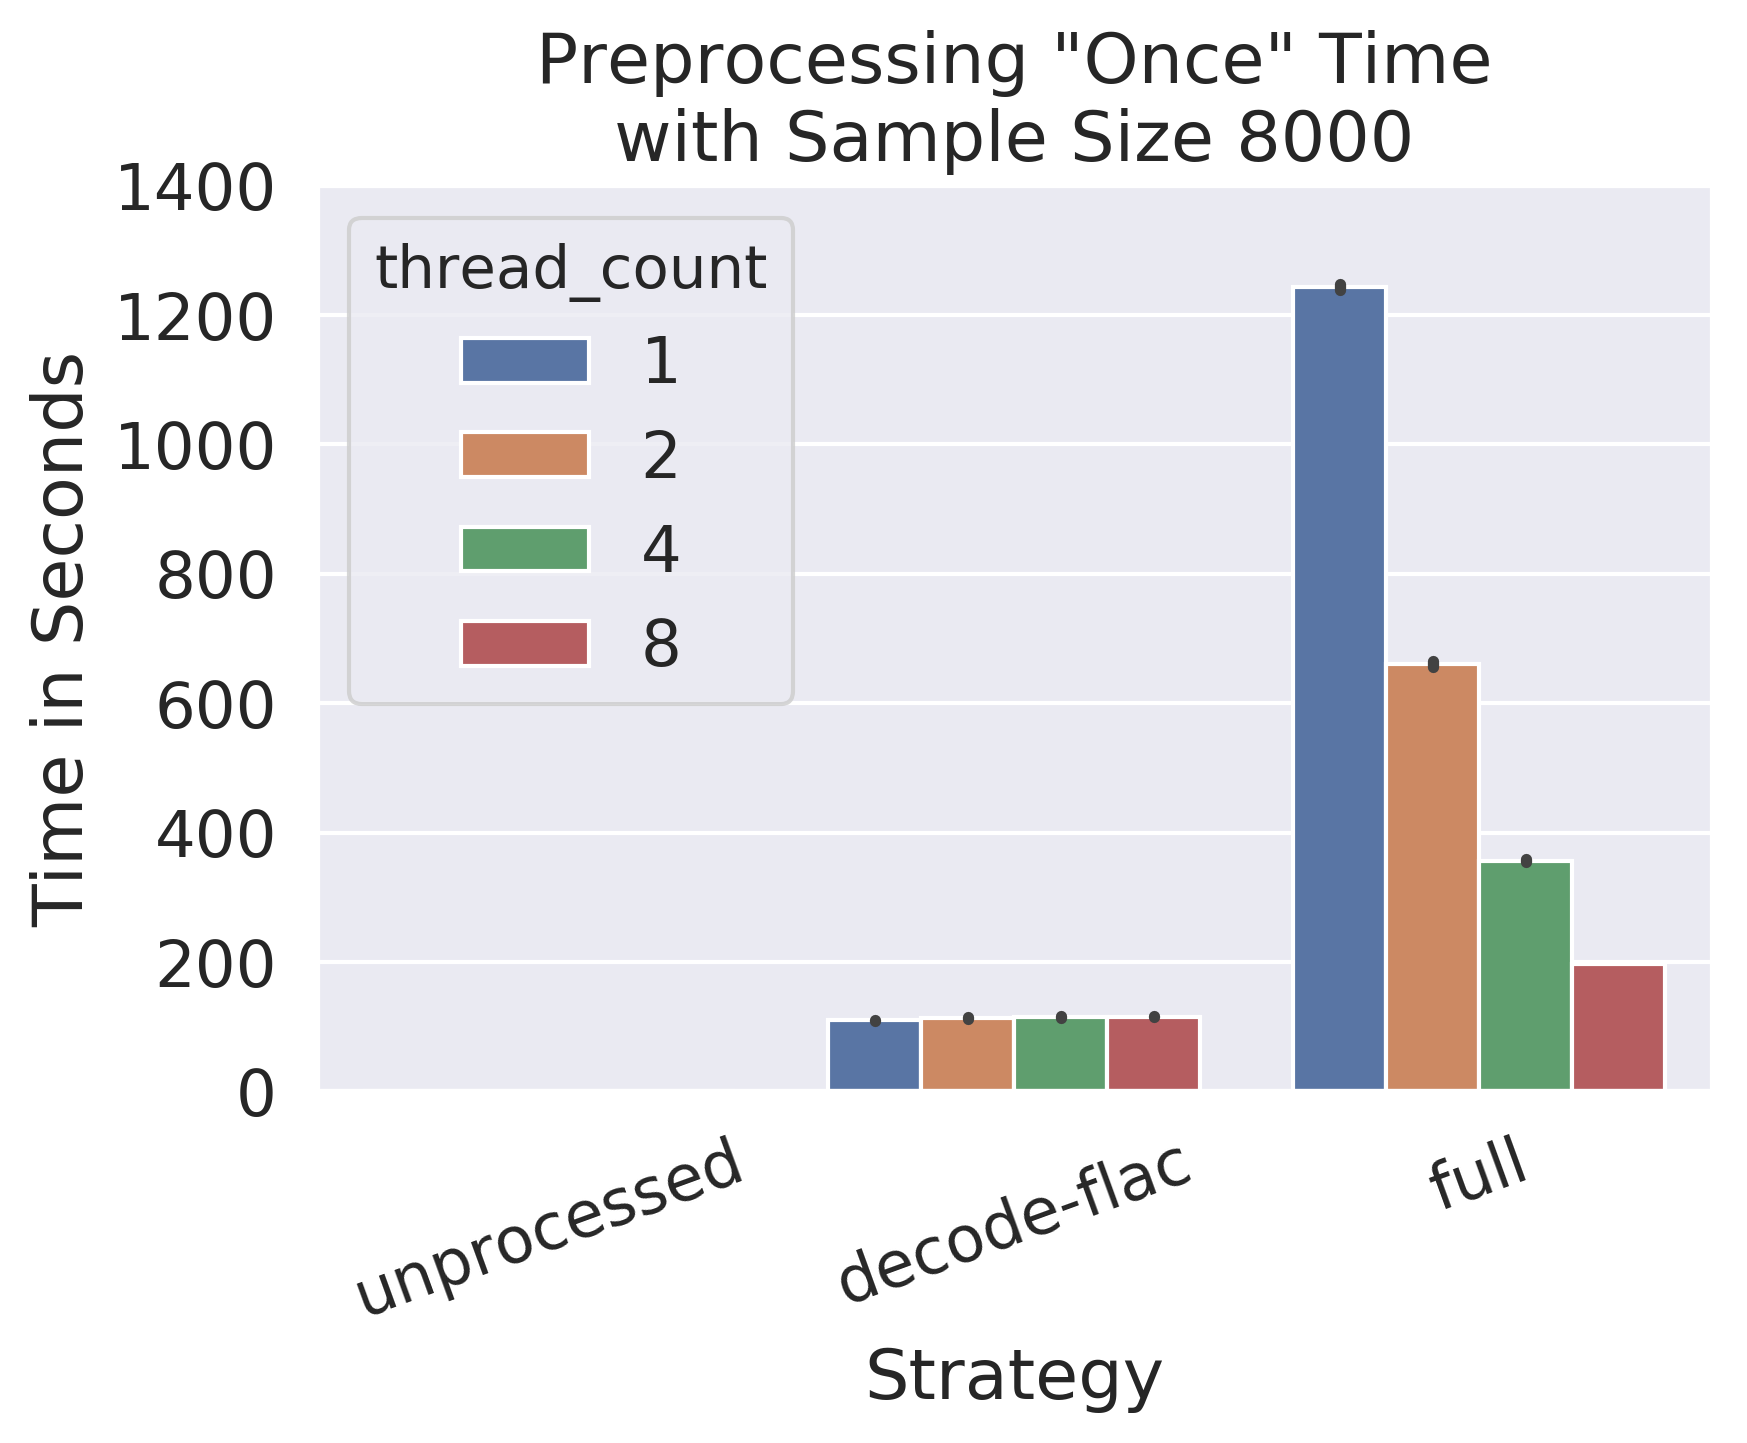

In [10]:
plot = sns.barplot(
    x="split_name",
    y="offline_processing_and_save_time_s",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Preprocessing \"Once\" Time\n with Sample Size 8000 {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 1400))

## 2.2 Unmarshalling Cost for Last Data Representation

[Text(0, 0.5, 'Time in Seconds'), Text(0.5, 0, 'Sample Count')]

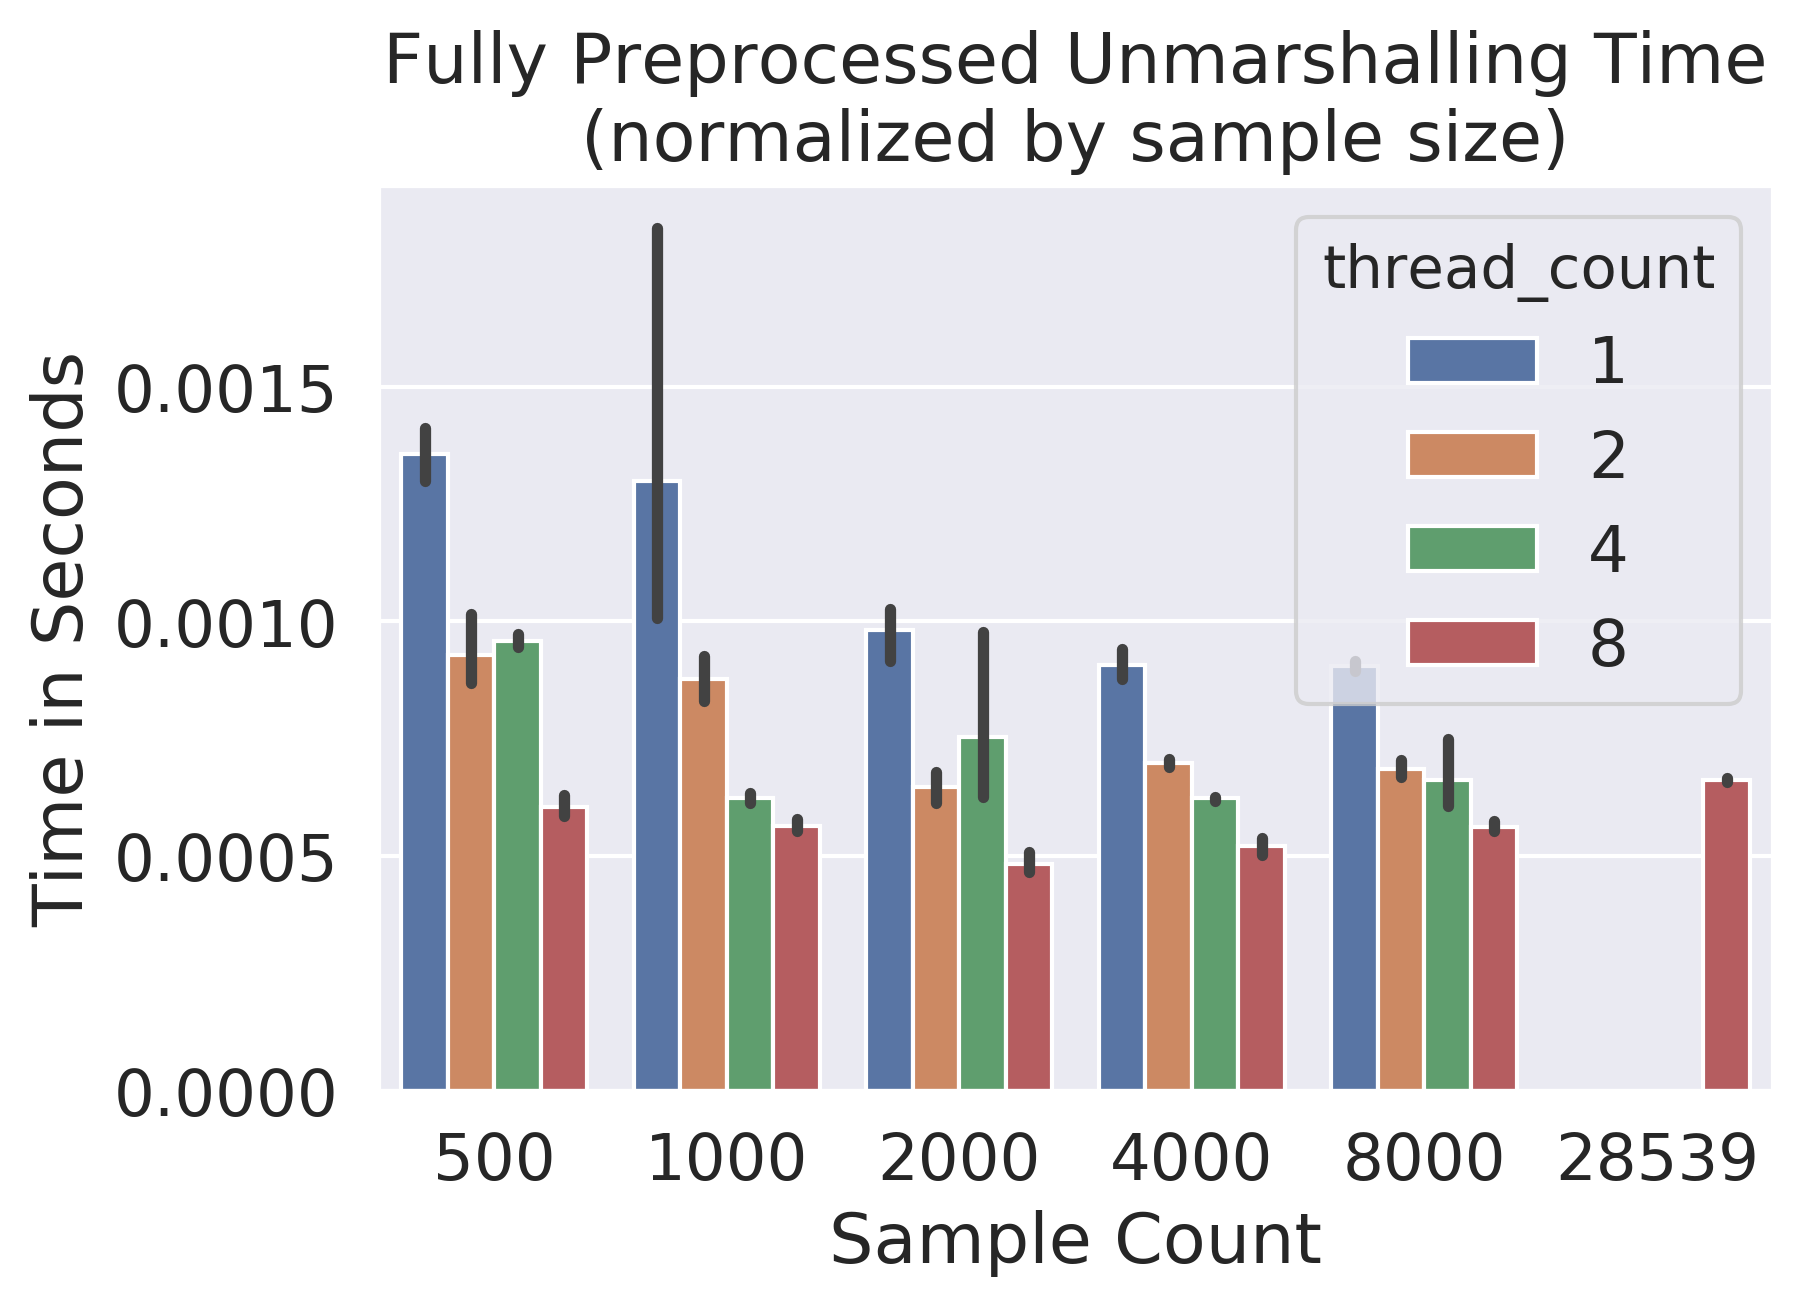

In [19]:
test_df = cum_df.copy(deep=True)
test_df["normalized_online_processing_time_s"] = test_df["online_processing_time_s"] / test_df["sample_count"]

plot = sns.barplot(
    x="sample_count",
    y="normalized_online_processing_time_s",
    hue="thread_count",
    data=test_df.query(f"split_name=='{strategies[-1]}'")
)
plot.set_title(f"Fully Preprocessed Unmarshalling Time\n(normalized by sample size){sampling_tag}")
plot.set(xlabel="Sample Count", ylabel="Time in Seconds")
#plot.set(ylim=(0,1.4))

# 3. Throughput Analysis

## 3.1 Throughput (sample_count = 8000)

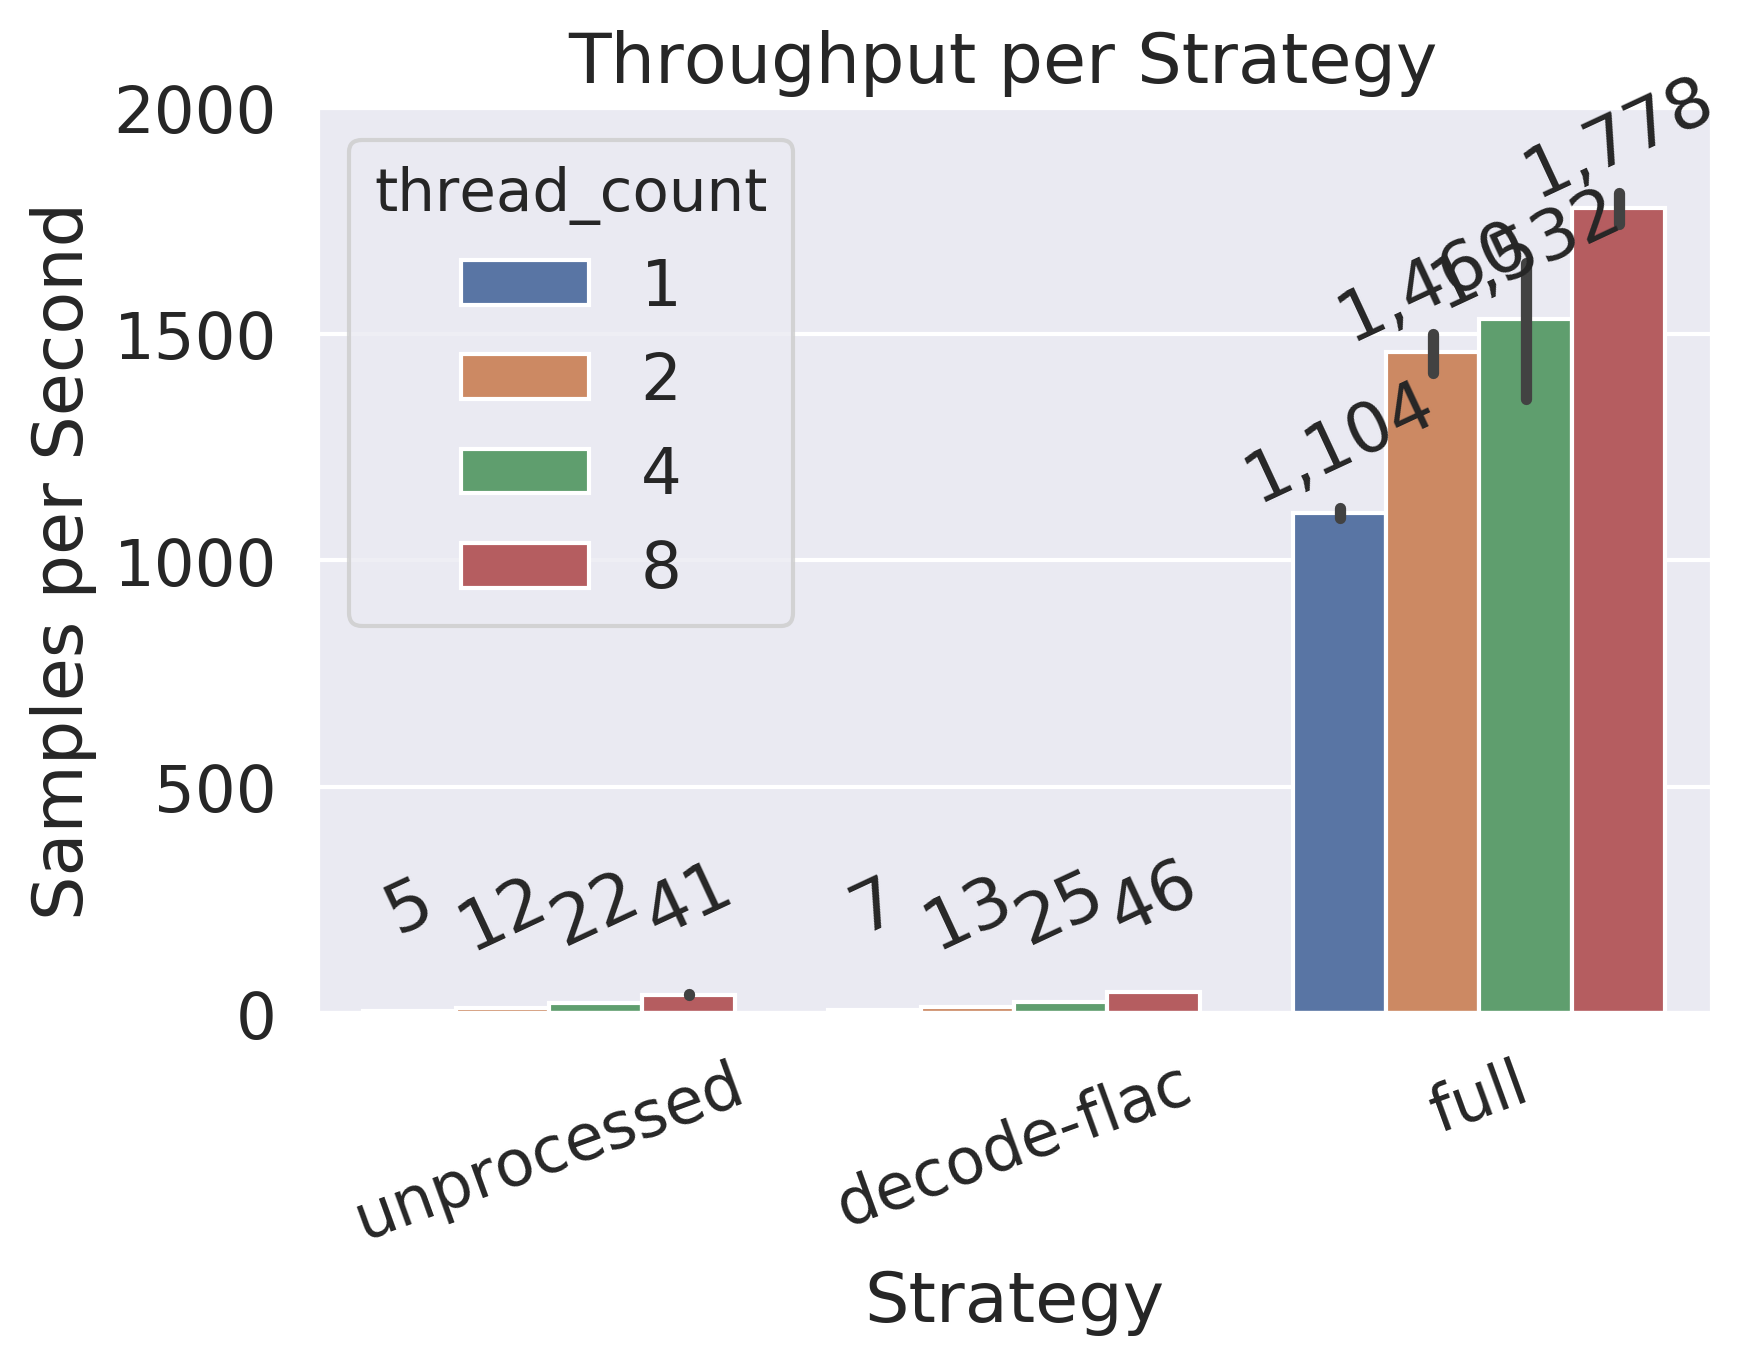

In [11]:
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Throughput per Strategy {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Samples per Second")
plot.set(ylim=(0, 2000))

#additional_space = [-180, -105, -150, 0, 0] \
#                 + [-50, 0, 0, 0, 0] \
#                 + [60, 0, -80, 0, 0] \
#                 + [0, 0, 0, 0, 100]
show_values_on_bars(plot, space=200)#, additional_space=additional_space)

### 2.2 Parallelization capabilities (sample_count = 8000)

In [12]:
cum_8000_df = cum_df.query("sample_count==8000")

par_capability = {
      "threads": []
    , "strategy": []
    , "speedup": []
}

def add_capability(threads, strategy, speedup):
    par_capability["threads"] += [threads]
    par_capability["strategy"] += [strategy]
    par_capability["speedup"] += [speedup]

for strategy in strategies:
    for thread_count in cum_df.thread_count.unique():
        throughputs = cum_8000_df.query(f"thread_count=={thread_count} and split_name=='{strategy}'")["throughput_sps"].to_numpy()
        for throughput in throughputs:
            avg_step_t1_throughput = cum_8000_df.query(f"thread_count=={1} and split_name=='{strategy}'")["throughput_sps"].mean()
            # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
            #if avg_step_t1_throughput < throughput:
            #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
            #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
            #else:
            #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
            #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
            ## now using speedup instead of increase/decrease factor
            speedup = throughput / avg_step_t1_throughput
            add_capability(thread_count, strategy, speedup)

capability_df = pd.DataFrame(par_capability)
capability_df

,threads,strategy,speedup
0,8,0-fully-online,6.883183
1,8,0-fully-online,7.009947
2,8,0-fully-online,7.001170
3,8,0-fully-online,7.024775
4,8,0-fully-online,7.038336
5,1,0-fully-online,0.996726
6,1,0-fully-online,0.996051
7,1,0-fully-online,1.003673
8,1,0-fully-online,0.972186
9,1,0-fully-online,1.031363


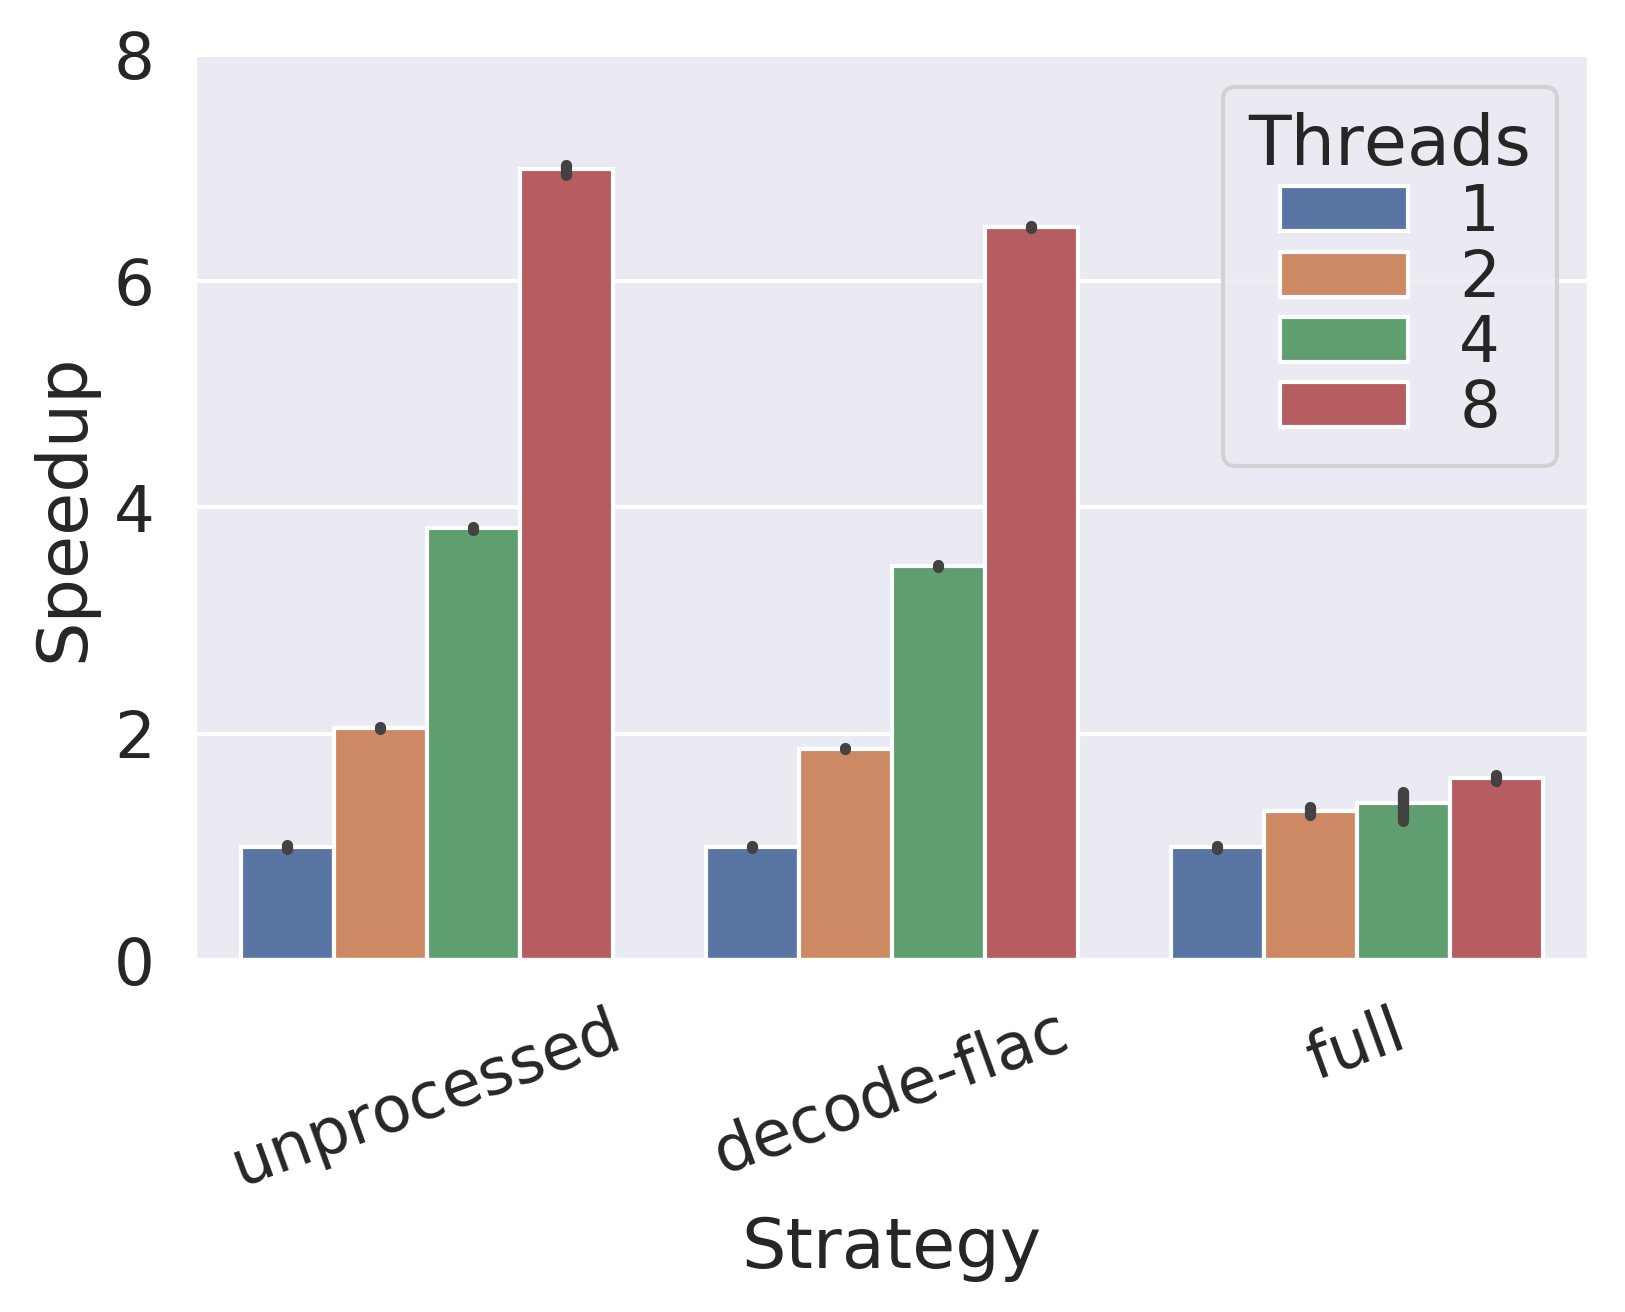

In [13]:
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="threads",
    data=capability_df
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
#plot.set_title(f"Speedup for Each Strategy Compared to\n Average Single Threaded Throughput\n with a Sample Size 8000")
plot.set(xlabel="Strategy", ylabel="Speedup")
plot.set(ylim=(0, 8))
plot.legend(title="Threads", ncol=1,labelspacing=0.05)
save_fig("speedup")

## 4. Extrapolation Capabilities

In [14]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]

# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_filecount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_filecount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df["full_dataset_offline_processing_and_save_time_h"] = cum_df["full_dataset_offline_processing_and_save_time_m"] / 60

# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60 
cum_df["full_dataset_processing_time_h"] = cum_df["full_dataset_processing_time_m"] / 60 

cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 28539, 'sample_count'] = '29K (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, 8000: 14, '29K (full)': 15}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))
cum_df_mod

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,...,per_sample_online_processing_time_s,per_sample_offline_processing_and_save_time_s,total_processing_time_s,full_dataset_online_processing_time_s,full_dataset_offline_processing_and_save_time_s,full_dataset_offline_processing_and_save_time_m,full_dataset_offline_processing_and_save_time_h,full_dataset_processing_time_s,full_dataset_processing_time_m,full_dataset_processing_time_h
15,0.000000,1,1,0.000000,500,81.880543,6.106457,0,5,79c43f,...,0.163761,0.000000,81.880543,4673.577660,0.000000,0.000000,0.000000,4673.577660,77.892961,1.298216
16,0.000000,1,1,0.000000,500,78.808632,6.344483,1,5,79c43f,...,0.157617,0.000000,78.808632,4498.239078,0.000000,0.000000,0.000000,4498.239078,74.970651,1.249511
17,0.000000,1,1,0.000000,500,80.838406,6.185179,2,5,79c43f,...,0.161677,0.000000,80.838406,4614.094543,0.000000,0.000000,0.000000,4614.094543,76.901576,1.281693
18,0.000000,1,1,0.000000,500,79.261473,6.308235,3,5,79c43f,...,0.158523,0.000000,79.261473,4524.086366,0.000000,0.000000,0.000000,4524.086366,75.401439,1.256691
19,0.000000,1,1,0.000000,500,78.789628,6.346013,4,5,79c43f,...,0.157579,0.000000,78.789628,4497.154361,0.000000,0.000000,0.000000,4497.154361,74.952573,1.249210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,804.108940,8,8,11572.116121,29K (full),18.997219,1502.272491,0,1,628c71,...,0.000666,0.028176,823.106159,18.997219,804.108940,13.401816,0.223364,823.106159,13.718436,0.228641
5,806.132568,8,8,11554.853721,29K (full),18.742536,1522.686165,0,1,f9b90d,...,0.000657,0.028247,824.875104,18.742536,806.132568,13.435543,0.223926,824.875104,13.747918,0.229132
8,804.849070,8,8,11580.890841,29K (full),18.917752,1508.583028,0,1,c43853,...,0.000663,0.028202,823.766823,18.917752,804.849070,13.414151,0.223569,823.766823,13.729447,0.228824
11,805.854177,8,8,11579.141721,29K (full),19.022650,1500.264177,0,1,d07863,...,0.000667,0.028237,824.876827,19.022650,805.854177,13.430903,0.223848,824.876827,13.747947,0.229132


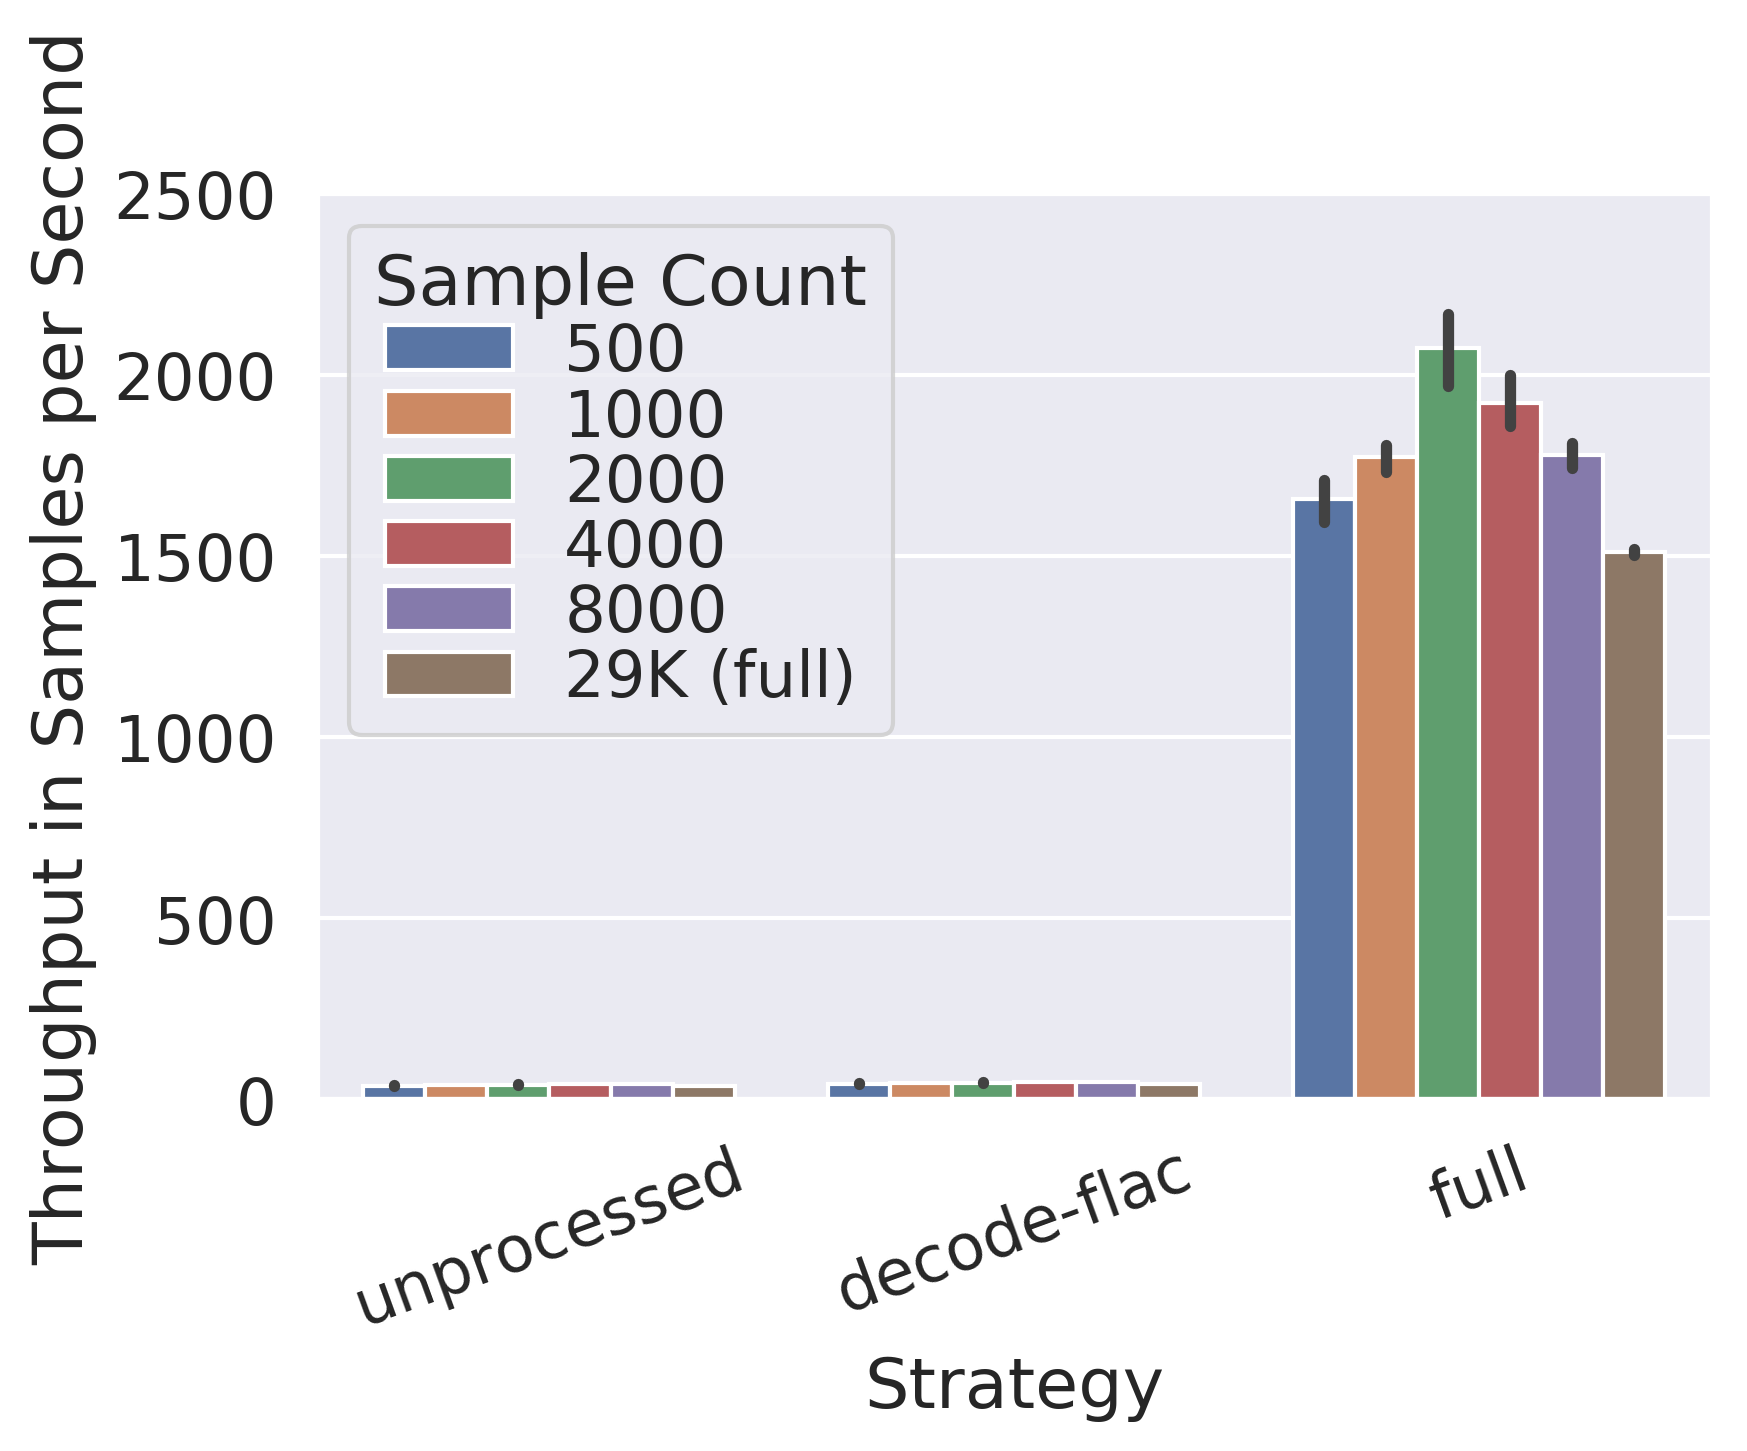

In [15]:
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
#plot.set_title(f"Throughput per Strategy with 8 Threads\n{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Second")
plot.set(ylim=(0, 2500))
plot.legend(title="Sample Count", ncol=1,labelspacing=0.05)
save_fig("throughput")

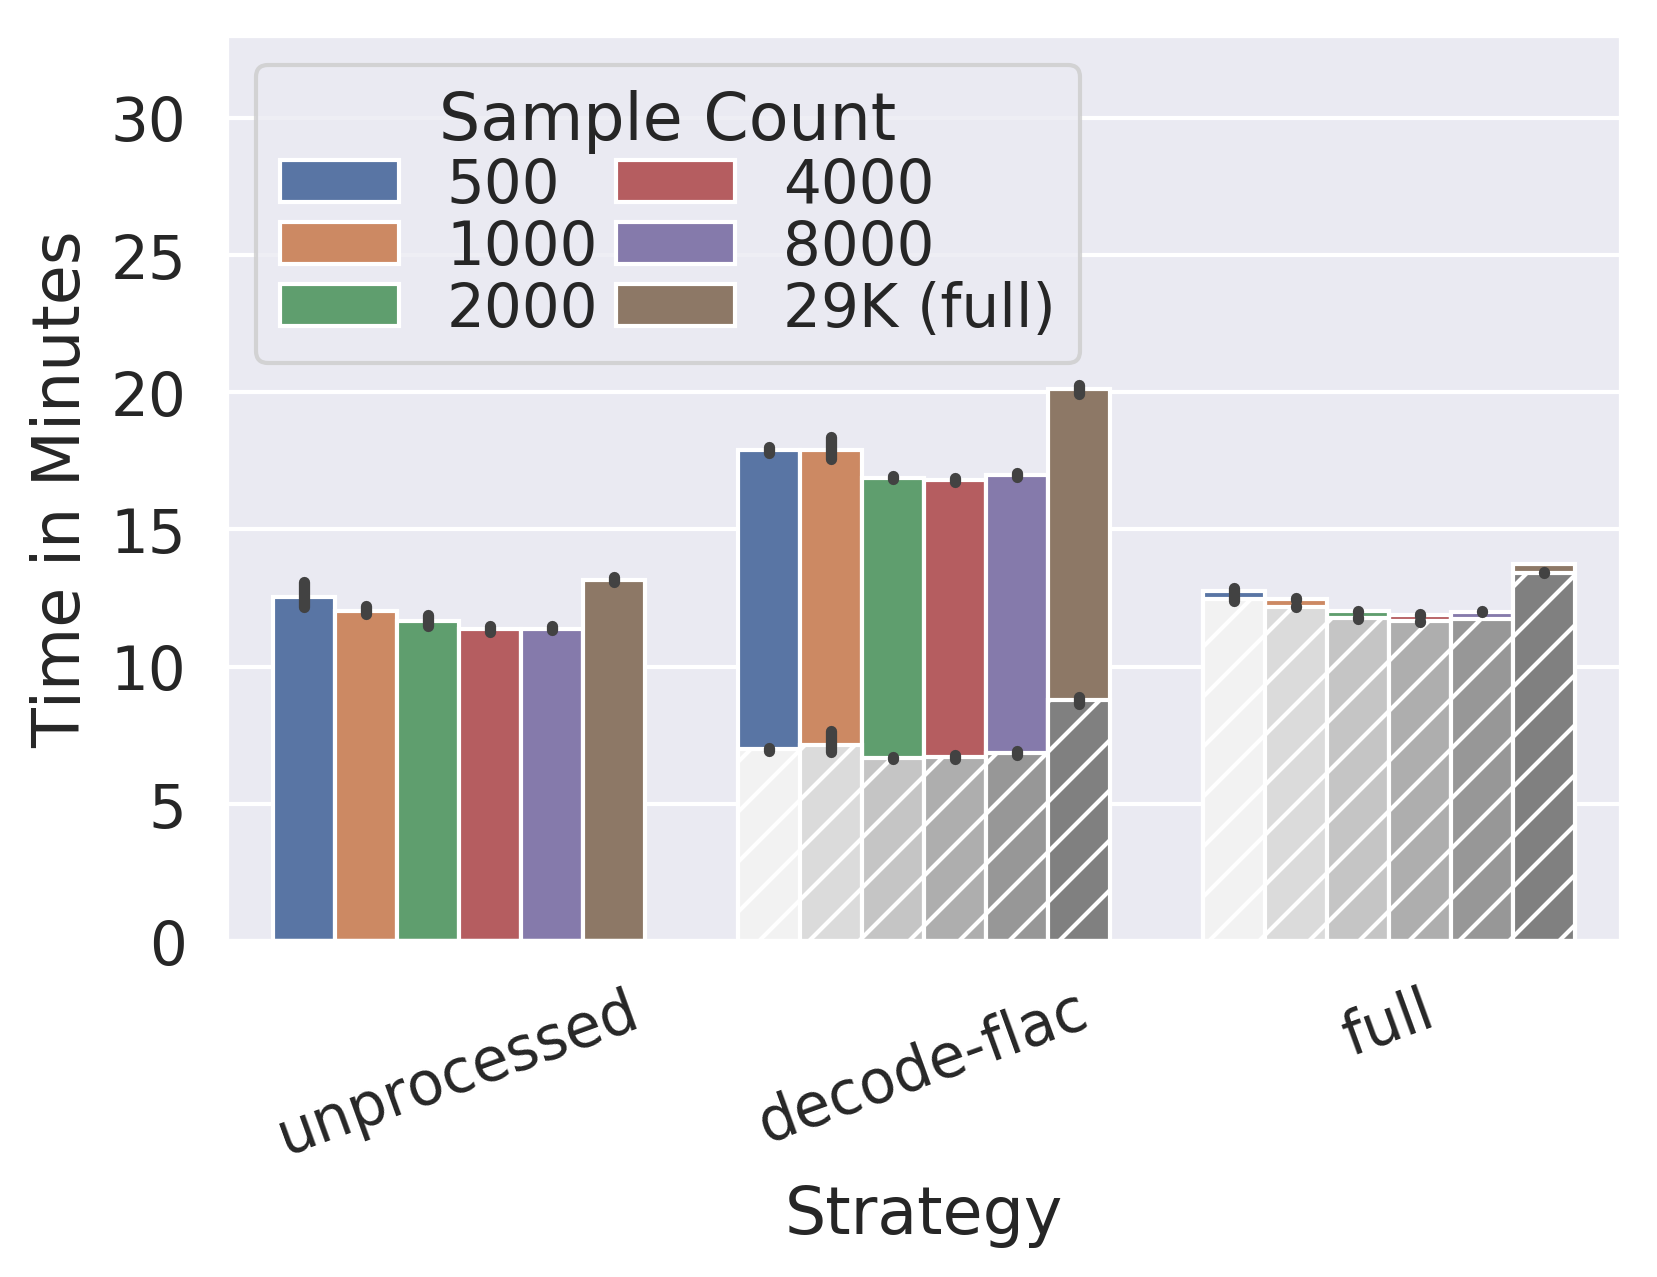

In [39]:
plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_m",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_m",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8"),
    color="grey"
)

sample_counts = len([500, 1000, 2000, 4000, 8000, '29K (full)']) 
bars_to_skip = sample_counts * len(strategies)
hatches = ['//'] * bars_to_skip
for i,bar in enumerate(plot.patches[bars_to_skip:]):
    bar.set_hatch(hatches[i])

#plot.set_title(f"Per Epoch Per Sample Processing Time\n for Each Strategy with 8 Threads{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Minutes")
plot.set(ylim=(0, 33))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper left", ncol=2, labelspacing=0.05, columnspacing=0.3)
save_fig("full-processing-time")

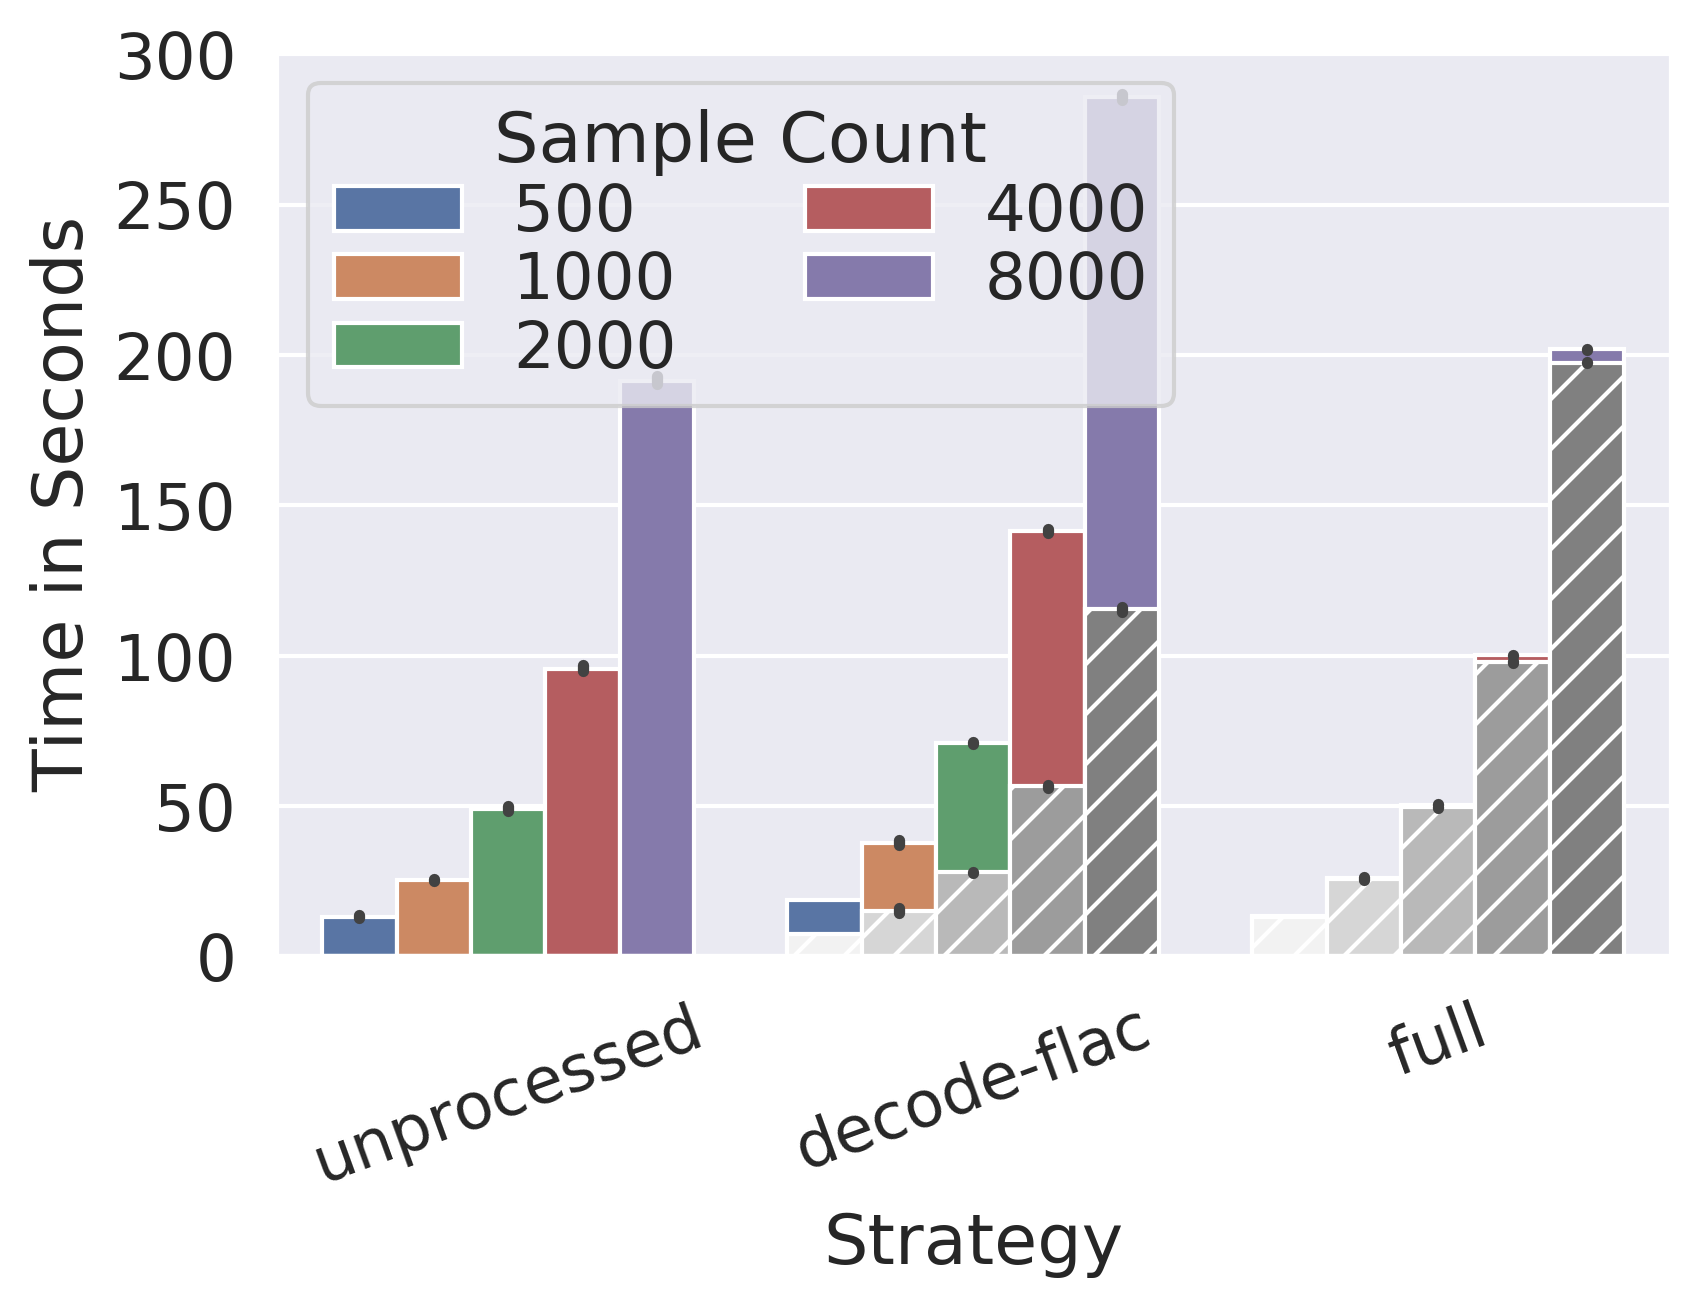

In [16]:
cum_df_preprocessing_time_comparison = cum_df_mod.query(f"thread_count==8 and sample_count!='29K (full)'")

plot = sns.barplot(
    x="split_name",
    y="total_processing_time_s",
    hue="sample_count",
    data=cum_df_preprocessing_time_comparison
)
plot = sns.barplot(
    x="split_name",
    y="offline_processing_and_save_time_s",
    hue="sample_count",
    data=cum_df_preprocessing_time_comparison,
    color="grey"
)

sample_counts = len([500, 1000, 2000, 4000, 8000])
bars_to_skip = sample_counts * len(strategies)
hatches = ['//'] * bars_to_skip
for i,bar in enumerate(plot.patches[bars_to_skip:]):
    bar.set_hatch(hatches[i])

#plot.set_title(f"Per Epoch Per Sample Processing Time\n for Each Strategy with 8 Threads{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
#plot.set(ylim=(0, 27))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper left", ncol=2, labelspacing=0.10)
save_fig("processing-time-per-sample-count")

# Warning - Creating the plots based on `dstat` logs can take several hours

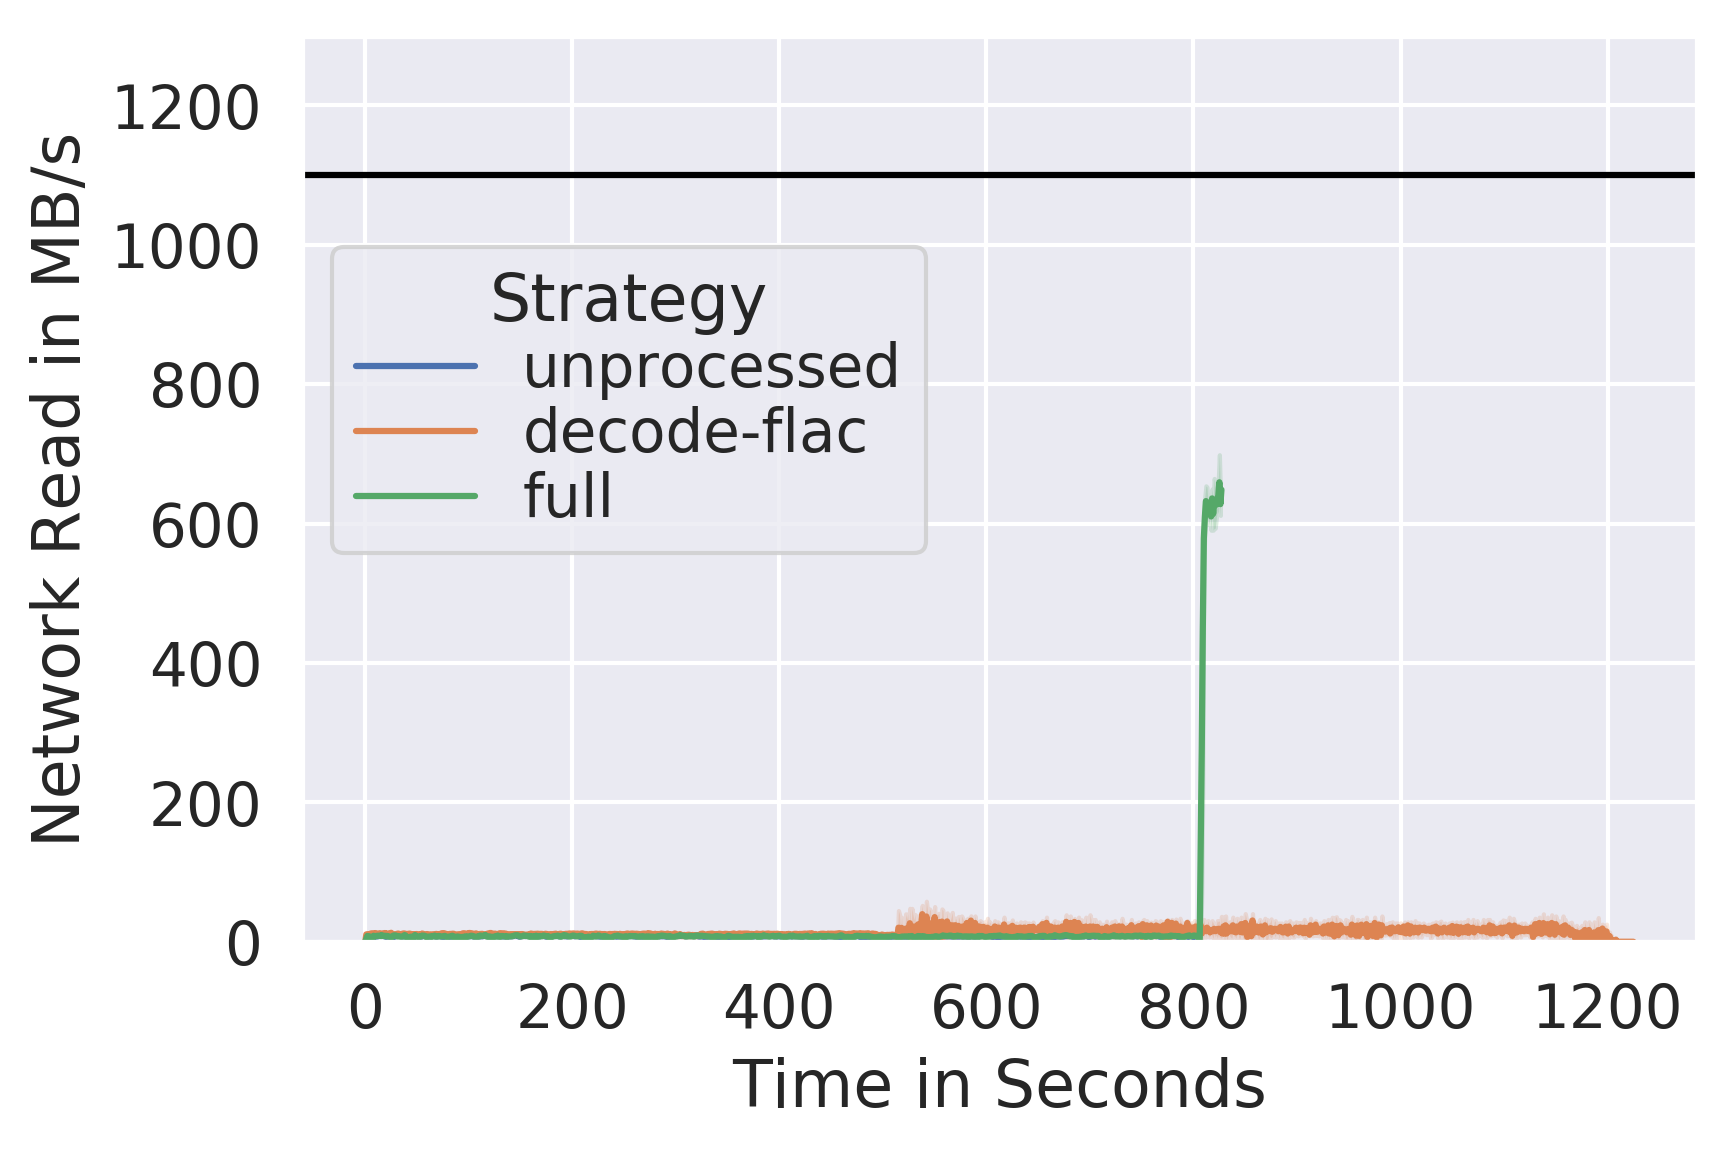

In [17]:
sns.set(font_scale=1.3)
test_df = cum_dstat_df.query(f"sample_count=={full_dataset_filecount}").copy(deep=True)
test_df["sample_count"] = test_df.sample_count.astype('category')
test_df["split_name"] = test_df.split_name.astype('category')
test_df["thread_count"] = test_df.thread_count.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="split_name",
    data=test_df.query("thread_count==8"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
plot.set(ylim=(0, 1300))
plot.axhline(1100, color="black")
plot.legend(strategies_renamed, title="Strategy", loc="upper left", bbox_to_anchor=(0,0.8), ncol=1,labelspacing=0.10)
save_fig("network-read-speed-t8-full", file_type="png")

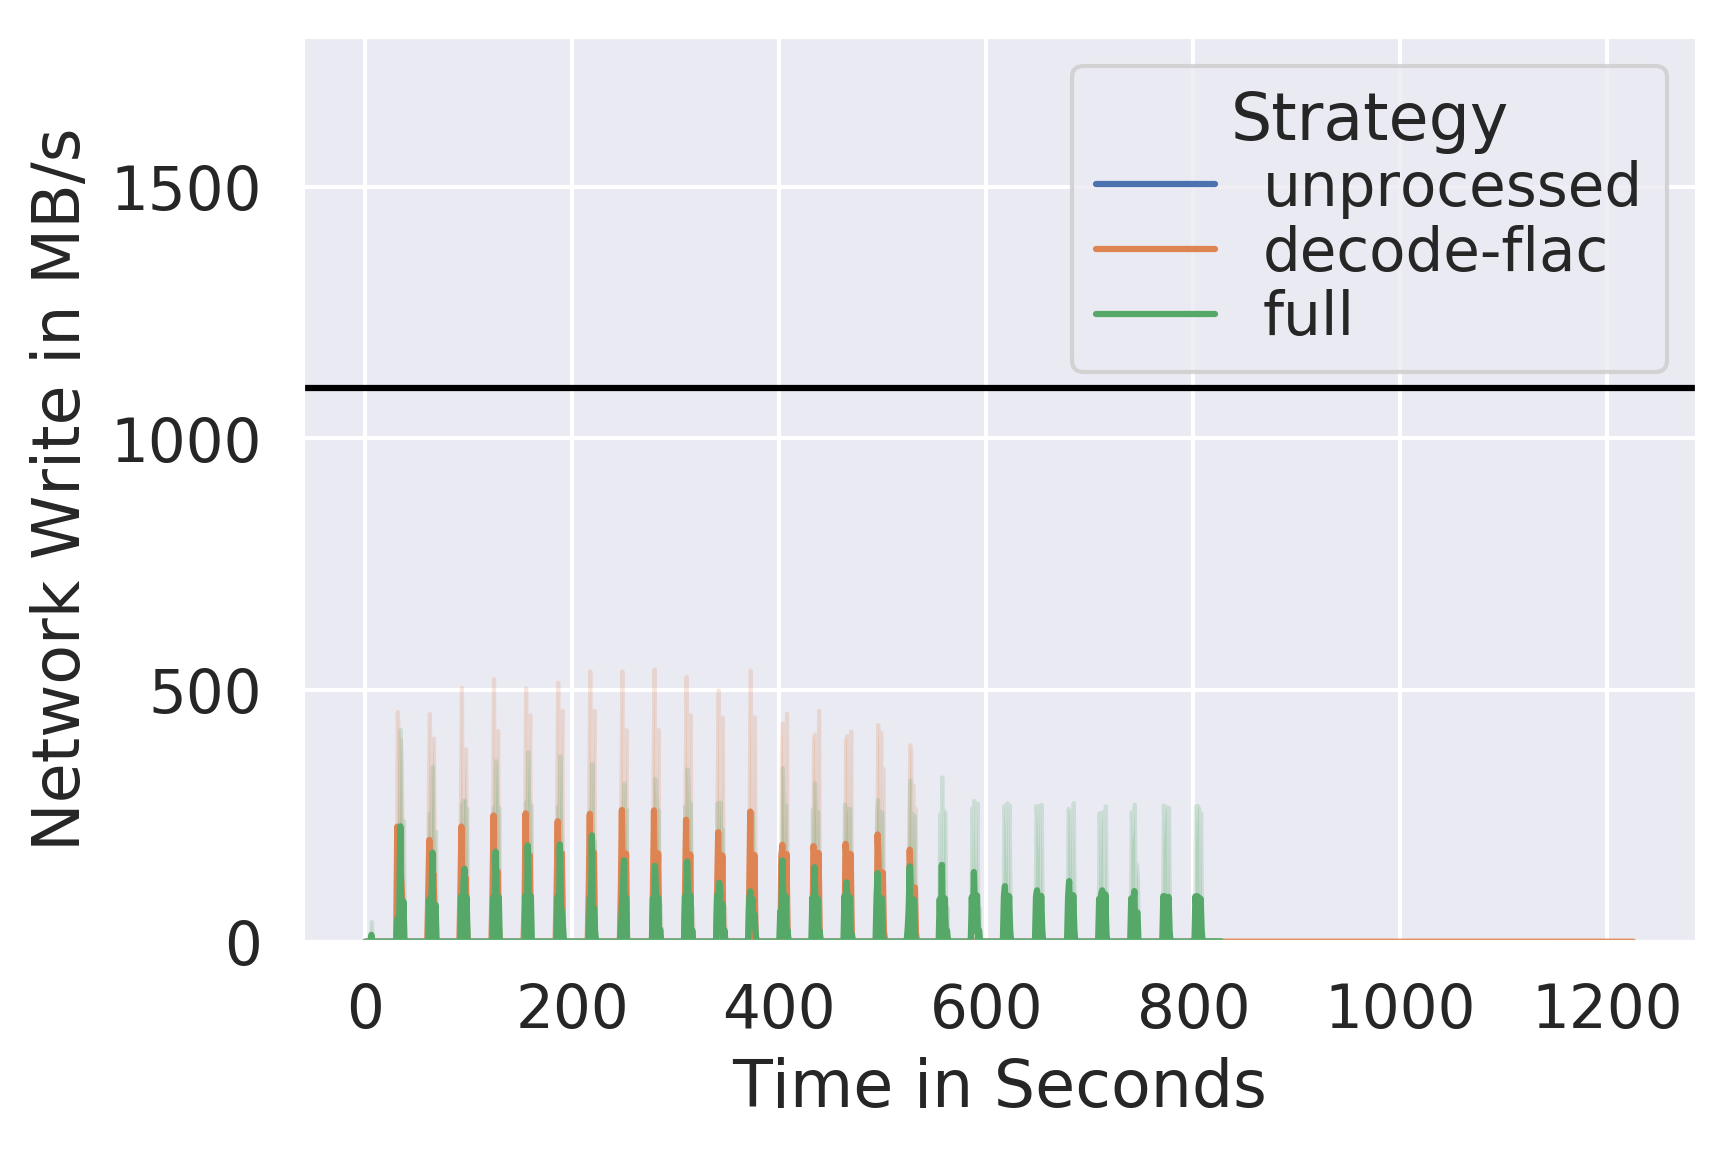

In [18]:
sns.set(font_scale=1.3)
test_df = cum_dstat_df.query(f"sample_count=={full_dataset_filecount}").copy(deep=True)
test_df["sample_count"] = test_df.sample_count.astype('category')
test_df["split_name"] = test_df.split_name.astype('category')
test_df["thread_count"] = test_df.thread_count.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="net_write_mbs",
    hue="split_name",
    data=test_df.query("thread_count==8"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Write in MB/s")
plot.set(ylim=(0, 1800))
plot.axhline(1100, color="black")
plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
save_fig("network-write-speed-t8-full", file_type="png")

In [19]:
step_1 = '0-fully-online'
step_2 = '2-read-and-decode-flac'
step_3 = '3-convert-to-spectrogram'
throughput_sps_step_1_t8 = cum_df.query(f"thread_count==8 and split_name=='{step_1}' and sample_count==8000")[['throughput_sps', 'split_name']].mean()[0]
throughput_sps_step_2_t8 = cum_df.query(f"thread_count==8 and split_name=='{step_2}' and sample_count==8000")[['throughput_sps', 'split_name']].mean()[0]
throughput_sps_step_3_t8 = cum_df.query(f"thread_count==8 and split_name=='{step_3}' and sample_count==8000")[['throughput_sps', 'split_name']].mean()[0]
throughput_sps_step_1_t1 = cum_df.query(f"thread_count==1 and split_name=='{step_1}' and sample_count==8000")[['throughput_sps', 'split_name']].mean()[0]
throughput_sps_step_2_t1 = cum_df.query(f"thread_count==1 and split_name=='{step_2}' and sample_count==8000")[['throughput_sps', 'split_name']].mean()[0]
throughput_sps_step_3_t1 = cum_df.query(f"thread_count==1 and split_name=='{step_3}' and sample_count==8000")[['throughput_sps', 'split_name']].mean()[0]
print(f"{step_1} + T1: {throughput_sps_step_1_t1}")
print(f"{step_1} + T8: {throughput_sps_step_1_t8}")
print(f"{step_2} + T1: {throughput_sps_step_2_t1}")
print(f"{step_2} + T8: {throughput_sps_step_2_t8}")
print(f"{step_3} + T1: {throughput_sps_step_3_t1}")
print(f"{step_3} + T8: {throughput_sps_step_3_t8}")
print(throughput_sps_step_1_t8 / throughput_sps_step_3_t1)

0-fully-online + T1: 5.977661648761429
0-fully-online + T8: 41.792715455799716
2-read-and-decode-flac + T1: 7.249822810771663
2-read-and-decode-flac + T8: 46.93178595756332
3-convert-to-spectrogram + T1: 1104.5687104745105
3-convert-to-spectrogram + T8: 1778.3157230513552
0.03783622970620454
